#**Tweet Emotion Recognition: Natural Language Processing with TensorFlow**

 ## **Task 1: Setup and Imports**

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import nlp

In [3]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [4]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

## **Task 2: Importing Data**

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [5]:
dataset=nlp.load_dataset('emotion')

Using custom data configuration default


In [6]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [7]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [8]:
def get_tweets(data):
  tweets=list(data['text'])
  labels=list(data['label'])
  return tweets, labels

In [9]:
tweets, labels= get_tweets(train)

In [10]:
tweets[0] , labels[0]

('i didnt feel humiliated', 'sadness')

## **Task 3: Tokenizer**

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer=Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(tweets)
print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## **Task 4: Padding and Truncating Sequences**

1. Checking length of the tweets
2. Creating padded sequences

<function matplotlib.pyplot.show>

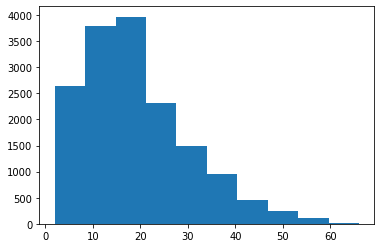

In [13]:
lengths=[len(t.split(' ')) for t in tweets]

plt.hist(lengths)
plt.show

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded_sequences=pad_sequences(sequences, padding='post', truncating='post', maxlen=50)
  return padded_sequences

In [16]:
padded_train_sequence=get_sequences(tokenizer, tweets)

In [17]:
padded_train_sequence[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## **Task 5: Preparing the Labels**

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [18]:
classes=set(labels)
print(classes)

{'joy', 'sadness', 'fear', 'surprise', 'love', 'anger'}


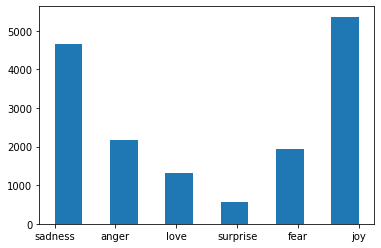

In [19]:
plt.hist(labels,bins=11)
plt.show()

In [20]:
classes_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_labels=dict((v,k) for v,k in enumerate(classes_to_index))

In [21]:
classes_to_index

{'anger': 5, 'fear': 2, 'joy': 0, 'love': 4, 'sadness': 1, 'surprise': 3}

In [22]:
index_to_labels

{0: 'joy', 1: 'sadness', 2: 'fear', 3: 'surprise', 4: 'love', 5: 'anger'}

In [23]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [24]:
train_labels = names_to_ids(labels)
print(train_labels[0])

1


## **Task 6: Creating the Model**

1. Creating the model
2. Compiling the model

In [25]:
model=tf.keras.models.Sequential([
                                  tf.keras.layers.Embedding(10000, 16, input_length=50),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                  tf.keras.layers.Dense(6, activation='softmax')
])
  
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## **Task 7: Training the Model**

1. Preparing a validation set
2. Training the model

In [26]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [27]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [28]:
h = model.fit(
    padded_train_sequence, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 21s 41ms/step - loss: 1.3613 - accuracy: 0.4746 - val_loss: 0.9410 - val_accuracy: 0.6625
Epoch 2/20
500/500 [==============================] - 19s 39ms/step - loss: 0.6639 - accuracy: 0.7639 - val_loss: 0.5960 - val_accuracy: 0.7890
Epoch 3/20
500/500 [==============================] - 19s 39ms/step - loss: 0.3736 - accuracy: 0.8792 - val_loss: 0.4832 - val_accuracy: 0.8460
Epoch 4/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2594 - accuracy: 0.9206 - val_loss: 0.5672 - val_accuracy: 0.8205
Epoch 5/20
500/500 [==============================] - 20s 41ms/step - loss: 0.1885 - accuracy: 0.9443 - val_loss: 0.4454 - val_accuracy: 0.8680
Epoch 6/20
500/500 [==============================] - 20s 40ms/step - loss: 0.1407 - accuracy: 0.9588 - val_loss: 0.4481 - val_accuracy: 0.8735
Epoch 7/20
500/500 [==============================] - 19s 39ms/step - loss: 0.1097 - accuracy: 0.9678 - val_loss: 0.4684 - val_accuracy:

## **Task 8: Evaluating the Model**

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

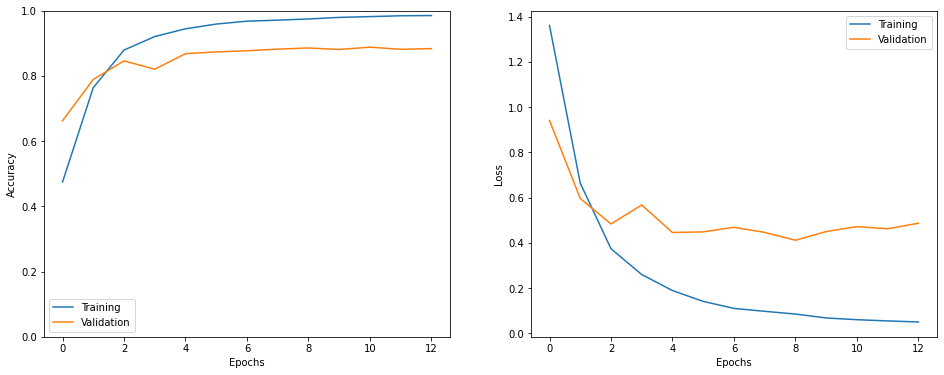

In [29]:
show_history(h)

In [30]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels= names_to_ids(test_labels)

In [31]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 11ms/step - loss: 0.4806 - accuracy: 0.8830


In [32]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_labels[test_labels[i]])

p = model.predict_classes(np.expand_dims(test_sequences[i], axis=0))[0]

print('Predicted Emotion:', index_to_labels.get(p))

Sentence: i never feel like im not supporting
Emotion: joy
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Predicted Emotion: joy


In [33]:
preds = model.predict_classes(test_sequences)
preds.shape, test_labels.shape

((2000,), (2000,))

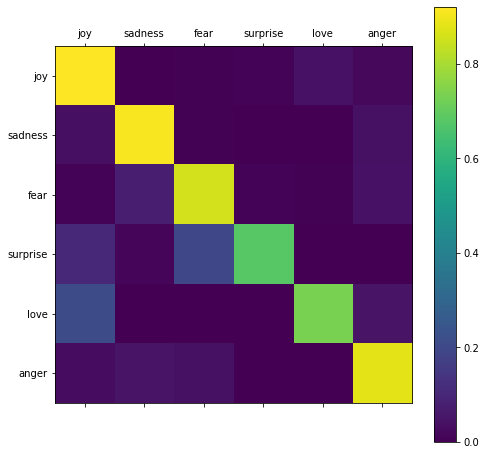

In [34]:
show_confusion_matrix(test_labels, preds, list(classes))